# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import pickle

# Load pickled data

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
n_train = len(y_train)

n_validation = len(y_valid)

n_test = len(y_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
# Get label mappings for display purposes
SIGNNAMES_CSV = 'signnames.csv'

label_mappings = dict()
signnames_df = pd.read_csv(SIGNNAMES_CSV, delimiter=',')
for idx, row in signnames_df.iterrows():
    label_mappings[int(row['ClassId'])] = row['SignName']

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

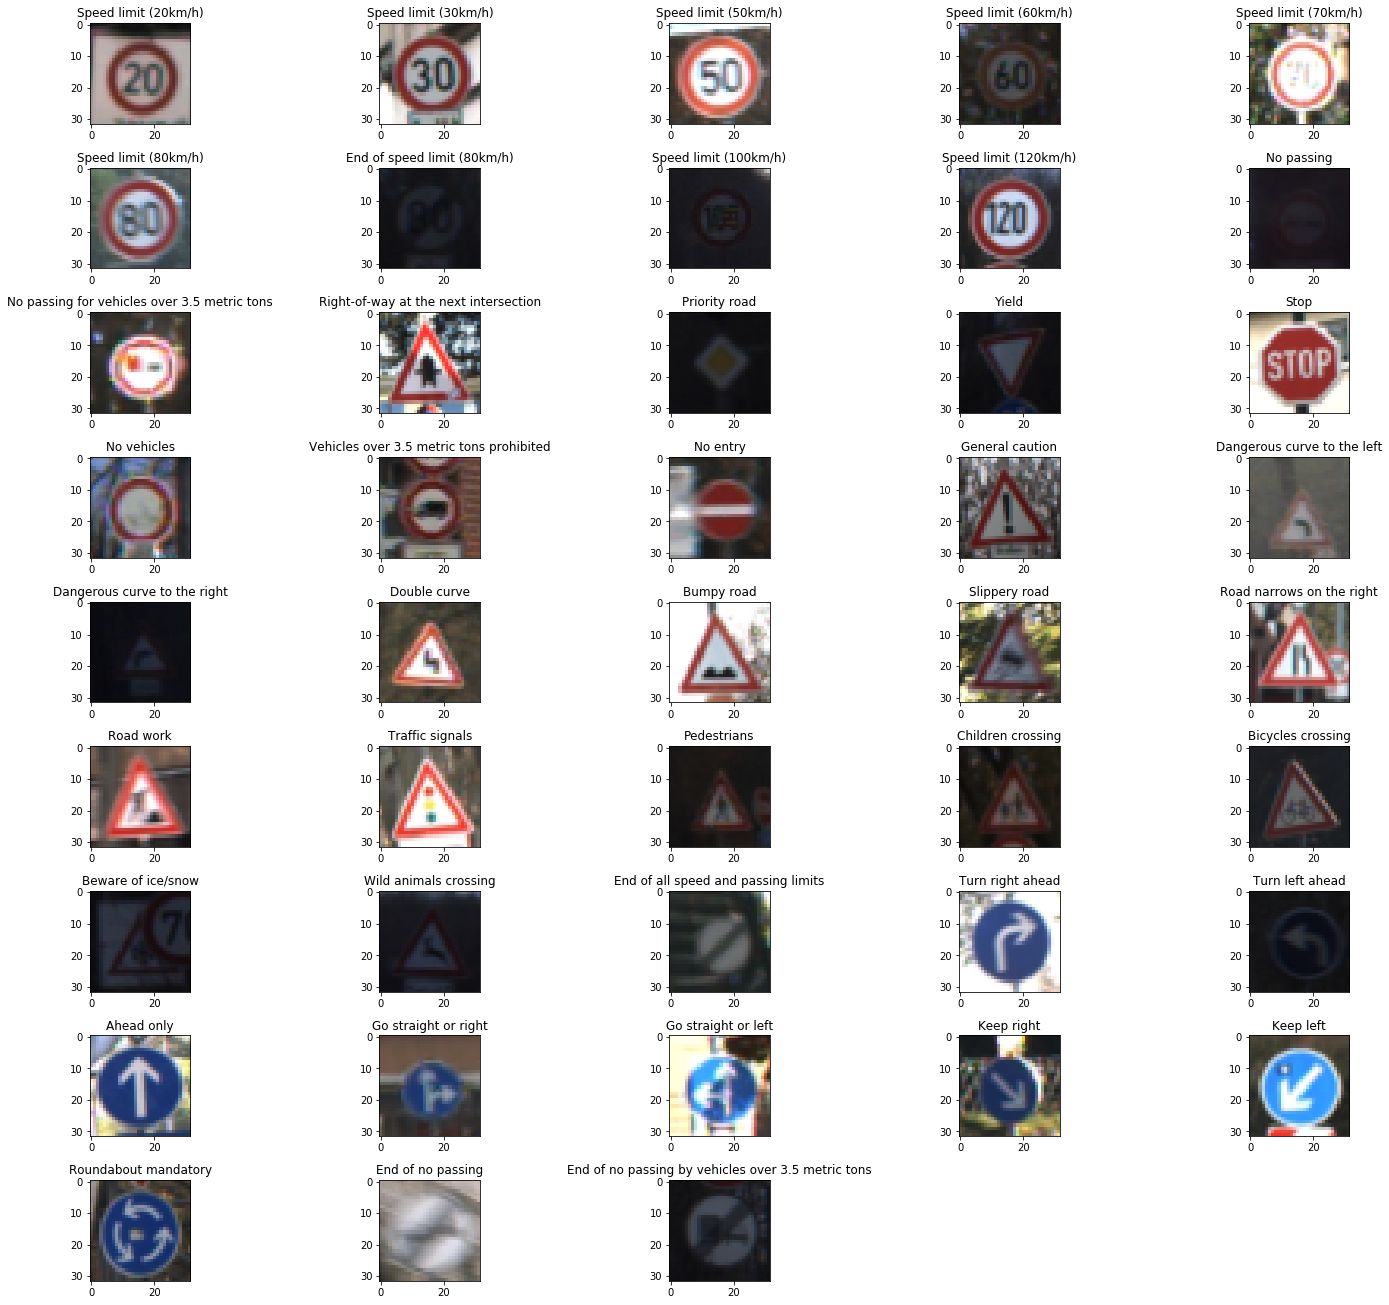

In [5]:
# See sample image from each class id
import random

# helper function to display grascale image of (width x height x 1) shape
def display_grayscale(grayscale_image):
    plt.imshow(np.resize(grayscale_image, 
                         (grayscale_image.shape[0],
                         grayscale_image.shape[1])), cmap = 'gray')

# randomly displays an image from each class
def display_image_per_class(X_train, y_train, label_mappings):
    fig = plt.figure(figsize=(20, 20))
    for classid in range(n_classes):
        image = random.choice(X_train[np.where(y_train == classid)])
        ax = fig.add_subplot(10, 5, classid + 1) 
        ax.set_title(label_mappings[classid])
        if (image.shape[2] == 3):
            plt.imshow(image)
        if (image.shape[2] == 1):
            display_grayscale(image)
    plt.tight_layout()
    plt.show()
    
display_image_per_class(X_train, y_train, label_mappings)

# some images are much darker than others

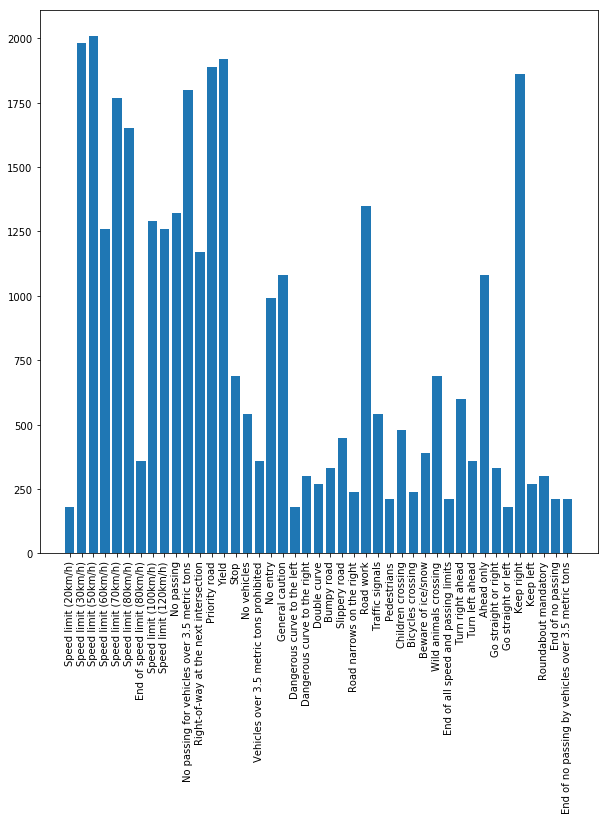

In [6]:
# distribution of classes
from collections import Counter

def display_class_distribution(y_train, label_mappings):
    plt.figure(figsize = (10, 10))
    counts = Counter(y_train)
    plt.bar([class_idx for class_idx in counts.keys()], counts.values())
    plt.xticks([class_idx for class_idx in counts.keys()],
               [label_mappings[class_idx] for class_idx in counts.keys()])
    plt.xticks(rotation='vertical')
    plt.show()

display_class_distribution(y_train, label_mappings)    
# Seems like quite an uneven distribution of each class label for the training set

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Distortions for Data Augmentation

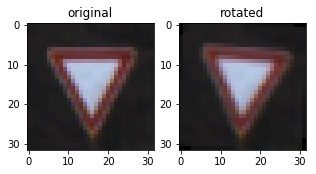

In [7]:
from skimage import transform

# apply random rotation between -10 degree left and 10 degree right
def random_rotation(image):
    random_degree = random.uniform(-5, 5)
    return transform.rotate(image, random_degree)

# test rotation
test_image = random.choice(X_train)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(test_image)
ax.set_title('original')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(random_rotation(test_image))
ax.set_title('rotated')
plt.show()

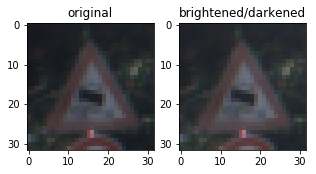

In [8]:
# add random brightness
def random_brightness(image):
    return  image + random.randint(-8, 8)

# test brightness
test_image = random.choice(X_train)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(test_image)
ax.set_title('original')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(random_brightness(test_image))
ax.set_title('brightened/darkened')
plt.show()

# not normalized so brightened image may display weird.
# normalization takes care of that later

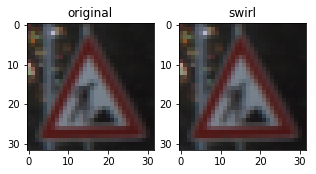

In [9]:
# swirl
def swirl(image):
    return transform.swirl(image,strength=1, radius = 10, mode='reflect', preserve_range=True)

# test swirl
test_image = random.choice(X_train)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(test_image)
ax.set_title('original')
ax = fig.add_subplot(1, 2, 2)
plt.imshow((swirl(test_image)).astype(int))
ax.set_title('swirl')
plt.show()

#### Preprocessing Functions

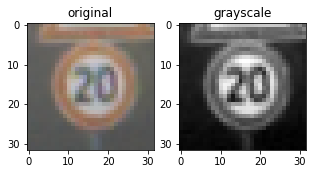

In [10]:
# convert image array from rgb to grayscale
def rgb2gray_image(rgb_image):
    return np.mean(rgb_image, axis=2, keepdims=True)

def rgb2gray_images(rgb_images):
    return [ rgb2gray_image(image) for image in rgb_images ]

# test rgb to grayscale
test_image = random.choice(X_train)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(test_image)
ax.set_title('original')
ax = fig.add_subplot(1, 2, 2)
display_grayscale(rgb2gray_image(test_image))
ax.set_title('grayscale')
plt.show()

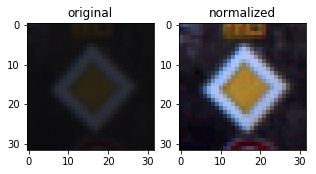

In [11]:
# normalize images, zero center
def normalize_images(images):
    return ((images - np.mean(images)) / (np.max(images) - np.min(images))).astype(np.float32)

# for plotting zero center normalized images
def display_normalized_image(normalized_image):
    plt.imshow(normalized_image - np.min(normalized_image))

# test normalization
test_image = random.choice(X_train)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(test_image)
ax.set_title('original')
ax = fig.add_subplot(1, 2, 2)
display_normalized_image(normalize_images(test_image))
ax.set_title('normalized')
plt.show()

#### Data augmentation and preprocessing

In [12]:
# Data augmentation

from collections import defaultdict
import random

# augment all classes by so that each class has at least min_size images each
# takes as input X_train and y_train and returns
# X_train and y_train pair with augmentations added
def augment_images(X_train, y_train, min_size):
    X_train_classified = defaultdict(list)
    for image, classid in zip(X_train, y_train):
        X_train_classified[classid].append(image)
    augmented_images = list()
    augmented_classids = list()
    for classid, images in X_train_classified.items():
        n_augmentations = min_size - len(images)
        if n_augmentations < 0:
            n_augmentations = 0
        for i in range(n_augmentations):
            #print(random.choice(images))
            augmented_image = random_rotation(swirl(random.choice(images)))
            augmented_images.append(augmented_image)
            augmented_classids.append(classid)
    return np.concatenate((X_train, augmented_images)), np.concatenate((y_train, augmented_classids))

X_train, y_train = augment_images(X_train, y_train, 1500)

In [13]:
# preprocessing

def preprocess_X(X):
    return normalize_images(rgb2gray_images(X))

X_train, X_valid, X_test = preprocess_X(X_train), preprocess_X(X_valid), preprocess_X(X_test)

In [14]:
from sklearn.utils import shuffle

# shuffle training data
X_train, y_train = shuffle(X_train, y_train)

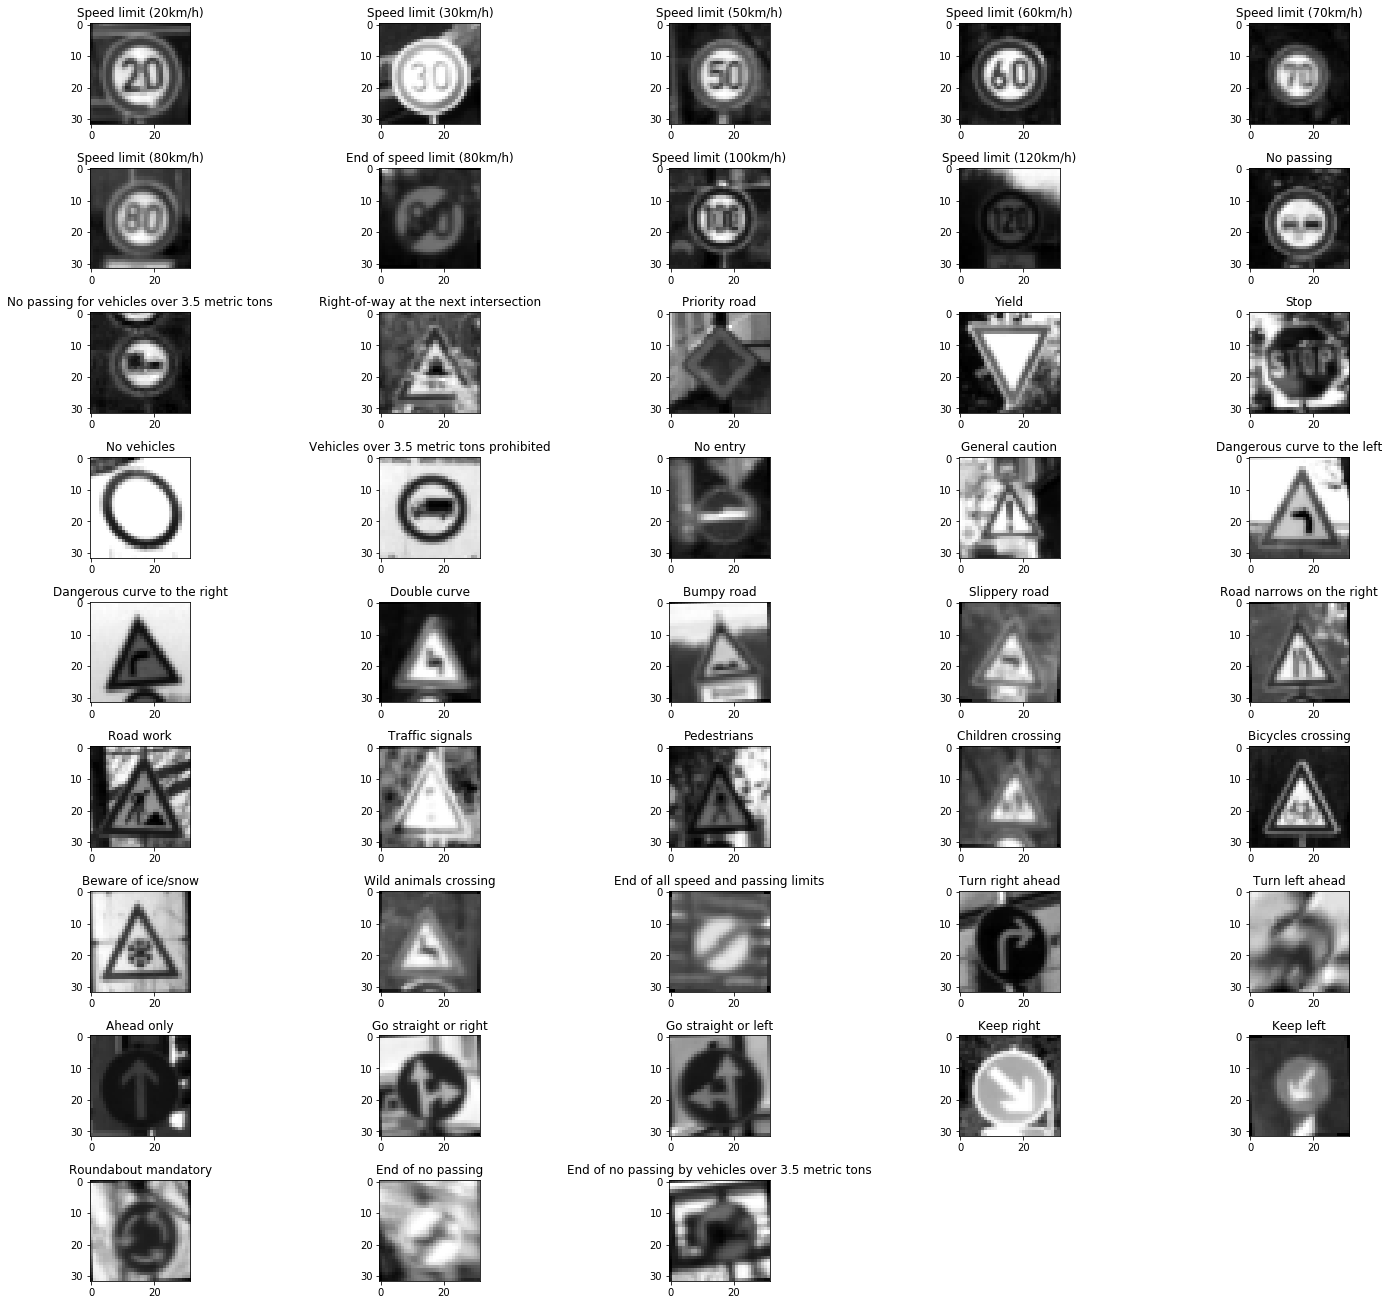

In [15]:
# See sample image from each class id
display_image_per_class(X_train, y_train, label_mappings)

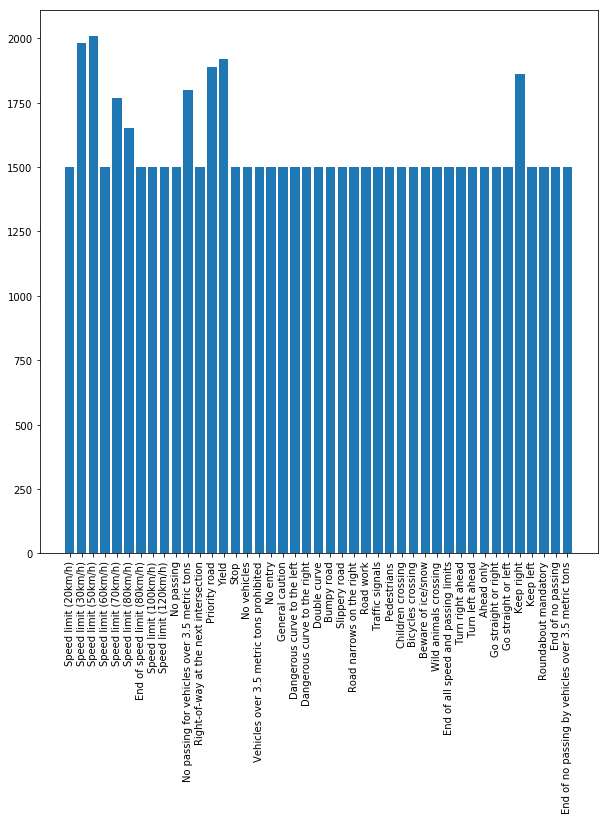

In [16]:
display_class_distribution(y_train, label_mappings)

### Model Architecture

In [17]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = image.shape (32 x 32 x 1). Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0_1   = flatten(conv2)
    fc0_2   = flatten(conv1) # 1176
    
    fc0 = tf.concat_v2([fc0_1, fc0_2], 1)
    
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 1576. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1576, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # return conv layers for visualization
    return logits, conv1, conv2

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
EPOCHS = 100
BATCH_SIZE = 128

In [19]:
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [20]:
rate = 0.001

logits, conv1, conv2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './save')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.796
Validation Accuracy = 0.738

EPOCH 2 ...
Training Accuracy = 0.899
Validation Accuracy = 0.830

EPOCH 3 ...
Training Accuracy = 0.938
Validation Accuracy = 0.893

EPOCH 4 ...
Training Accuracy = 0.957
Validation Accuracy = 0.913

EPOCH 5 ...
Training Accuracy = 0.960
Validation Accuracy = 0.910

EPOCH 6 ...
Training Accuracy = 0.972
Validation Accuracy = 0.930

EPOCH 7 ...
Training Accuracy = 0.976
Validation Accuracy = 0.939

EPOCH 8 ...
Training Accuracy = 0.981
Validation Accuracy = 0.947

EPOCH 9 ...
Training Accuracy = 0.982
Validation Accuracy = 0.943

EPOCH 10 ...
Training Accuracy = 0.984
Validation Accuracy = 0.950

EPOCH 11 ...
Training Accuracy = 0.987
Validation Accuracy = 0.953

EPOCH 12 ...
Training Accuracy = 0.988
Validation Accuracy = 0.959

EPOCH 13 ...
Training Accuracy = 0.990
Validation Accuracy = 0.959

EPOCH 14 ...
Training Accuracy = 0.990
Validation Accuracy = 0.960

EPOCH 15 ...
Training Accuracy = 0.991
Valid

In [23]:
#0.908 with just normalization and rgbtogray
#0.913 with rotation of -5, 5
#0.905 with rotation -10, 10
#0.914 with brightness -10, 10
#0.913 with rotation -7.5, 7.5 brightness -10, 10
#0.897 with rotation -7.5, 7.5 brightness -20, 20
#0.912 with rotation -7.5, 7.5 brightness -15, 15
#0.896 with rotation -7.5, 7.5 brightness -8, 8
#0.914 with rotation -5, 5 brightness -8, 8

In [24]:
# TODO: restore from .save file
# on test set 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

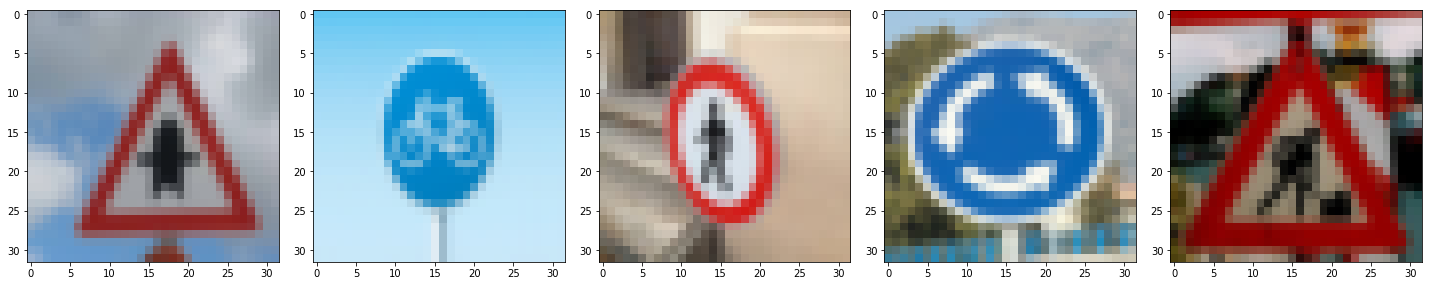

In [25]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# resize image
def resize_image(image, resize_shape = (32, 32, 3)):
    return transform.resize(image, resize_shape, mode='reflect', anti_aliasing=True)

ADDITIONAL_TEST_IMAGES_DIR = 'downloaded_images'

additional_test_images = []

for file in os.listdir(ADDITIONAL_TEST_IMAGES_DIR):
    try:
        image = mpimg.imread(ADDITIONAL_TEST_IMAGES_DIR + '/' + file)
        additional_test_images.append(resize_image(image))
    except:
        pass

# displays resized images
fig = plt.figure(figsize=(20, 20))
for idx, image in enumerate(additional_test_images):
    ax = fig.add_subplot(1, 5, idx+1)
    plt.imshow(image)
    plt.tight_layout()
plt.show()

In [26]:
# preprocess images
additional_test_images = preprocess_X(additional_test_images)

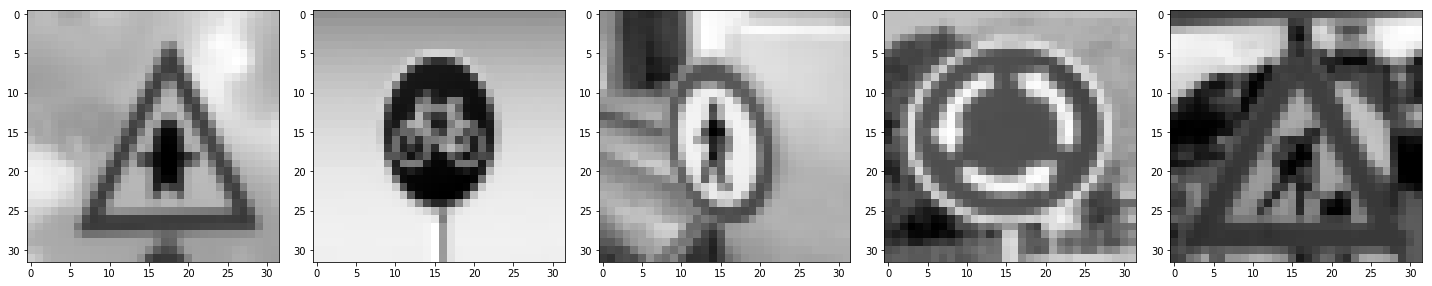

In [27]:
# displays preprocessed images
fig = plt.figure(figsize=(20, 20))
for idx, image in enumerate(additional_test_images):
    ax = fig.add_subplot(1, 5, idx+1)
    display_grayscale(image)
    plt.tight_layout()
plt.show()

### Predict the Sign Type for Each Image

In [28]:
# manually assign labels
additional_test_images_labels = [11, 29, 27, 40, 25]
for class_id in additional_test_images_labels:
    print(label_mappings[class_id])

Right-of-way at the next intersection
Bicycles crossing
Pedestrians
Roundabout mandatory
Road work


In [29]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
# on test set 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    results = sess.run(logits, feed_dict={x: additional_test_images, y: additional_test_images_labels, keep_prob:1.0})

# output of model on additional test images
print([label_mappings[np.argmax(result)] for result in results])
# classified Bicycles crossing, Pedestrians and Children crossing wrongly!

['Right-of-way at the next intersection', 'Turn left ahead', 'Road work', 'Roundabout mandatory', 'Road work']


### Analyze Performance

In [30]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
# on test set 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(additional_test_images, additional_test_images_labels)
    print("Accuracy = {:.3f}".format(test_accuracy))

Accuracy = 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [31]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_5_softmax_probs = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: additional_test_images, y: additional_test_images_labels, keep_prob:1.0})

print(top_5_softmax_probs)
# predicts the top choice with quite high certainty, > 90%, with the exception of the last image: road work

TopKV2(values=array([[  1.00000000e+00,   2.35744388e-12,   1.38335483e-13,
          7.01159779e-14,   5.37792633e-18],
       [  8.27788770e-01,   9.65792462e-02,   1.91663951e-02,
          1.76555850e-02,   9.59372986e-03],
       [  6.76205039e-01,   2.45292887e-01,   7.40652606e-02,
          2.81436672e-03,   5.20603033e-04],
       [  9.99999881e-01,   1.13689168e-07,   2.00968409e-10,
          2.57946655e-14,   6.90835095e-16],
       [  9.65307355e-01,   1.70792602e-02,   1.47110950e-02,
          2.89503252e-03,   5.98974884e-06]], dtype=float32), indices=array([[11, 30, 27, 21, 23],
       [34, 38, 17, 40, 30],
       [25,  1, 18,  4, 11],
       [40,  7, 12,  1, 10],
       [25, 11, 30, 20, 18]], dtype=int32))


In [32]:
# Check road work top 5 softmax probabilities
road_work = top_5_softmax_probs[1][4]
print([label_mappings[classidx] for classidx in road_work])

# completely predicts wrongly!

['Road work', 'Right-of-way at the next intersection', 'Beware of ice/snow', 'Dangerous curve to the right', 'General caution']


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [33]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

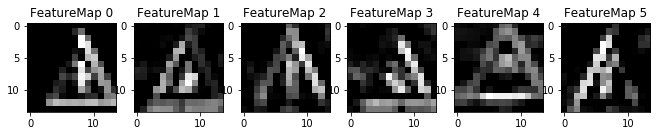

In [39]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(additional_test_images, conv1)